# An Autoencoder in Flux

http://fluxml.ai

* Flux is based on the julia language.

* Julia is a powerfully expressive and blazingly fast modern language, especially strong in numerical computing.
* Julia solves the "two language problem" in scientific computing (run julia code, *fast* on the GPU!)
* Flux is solving the two language problem in ML

## Installation

Download julia-1.0.2 from https://julialang.org/downloads

In julia package mode (press `]`)
```julia
pkg (v1.0)> add Flux
```

If you want GPU support, you'll need to install the nvidia drivers, cuda toolkit and cudnn separately, and add the `CuArrays` package

```julia
pkg (v1.0)> add CuArrays
```

## Extras


```julia
pkg (v1.0)> add Plots
pkg (v1.0)> add Measures
```

To make julia known to your main jupyter environment (called base here):
```bash
conda activate base
```

```julia
julia> ENV["PYTHON"] = readlines(`which python`)[1]
julia> ENV["JUPYTER"] = readlines(`which jupyter`)[1]
pkg (v1.0)> add IJulia
```



# The data

Again, we cheat, loading the data from the builtin example dataset.

In [2]:
using Flux.Data.MNIST
using Plots, Measures

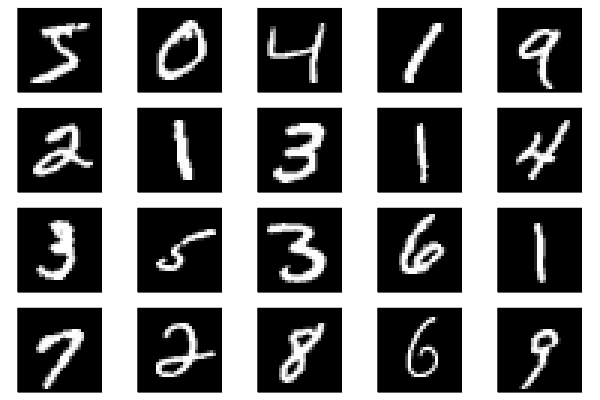

In [3]:
plot(heatmap.(MNIST.images()[1:20])...,
     aspectratio=:equal, xticks=nothing, yticks=nothing, margin=0mm)

# Two layer autoencoder

Adapted from the Flux Model Zoo
https://github.com/FluxML/model-zoo

# Prepare data

In [5]:
using Flux, Flux.Data.MNIST
using Flux: @epochs, onehotbatch, mse, binarycrossentropy, throttle
using Base.Iterators: partition
using CuArrays

imgs = MNIST.images()

# Reshape and partition into batches of size 1000
data = [float(hcat(vec.(imgs)...)) for imgs in partition(imgs, 1000)]

# Move data to the GPU (if CuArrays is loaded)
data = gpu.(data)

size(data[1])

(784, 1000)

# Define the model

In [6]:
N = 32 # Size of the encoding

# You can try to make the encoder/decoder network larger
# Also, the output of encoder is a coding of the given input.
# In this case, the input dimension is 28^2 and the output dimension of
# encoder is 32. This implies that the coding is a compressed representation.
# We can make lossy compression via this `encoder`.
encoder = Dense(28^2, N, leakyrelu) |> gpu
decoder = Dense(N, 28^2, leakyrelu) |> gpu

model = Chain(encoder, decoder)

Chain(Dense(784, 32, NNlib.leakyrelu), Dense(32, 784, NNlib.leakyrelu))

# Define loss function and train

In [7]:
loss(x) = mse(model(x), x)
#loss(x) = binarycrossentropy(model(x), x, ϵ=1e-4)

# evalcb = throttle(() -> @show(loss(data[1])), 1)
opt = ADAM(params(model))

for i=1:20
    @info "Epoch $i" loss(data[1])
    Flux.train!(loss, zip(data), opt) #, cb = evalcb)
end

┌ Info: Epoch 1
│   loss(data[1]) = 0.10390992f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 2
│   loss(data[1]) = 0.06118969f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 3
│   loss(data[1]) = 0.04132589f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 4
│   loss(data[1]) = 0.03269953f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 5
│   loss(data[1]) = 0.028044559f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 6
│   loss(data[1]) = 0.024523223f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 7
│   loss(data[1]) = 0.021819578f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 8
│   loss(data[1]) = 0.020010438f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 9
│   loss(data[1]) = 0.018748274f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 10
│   loss(data[1]) = 0.017848767f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 11
│   loss(data[1]) = 0.017180894f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 12
│   loss(data[1]) = 0.016663428f0 (tracked)
└ @ Main In[7]:8
┌ Info: Epoch 13
│   loss(data[1]) = 0.016227247f0 (tracked)
└ @ Main In[7]:8

# Sample output

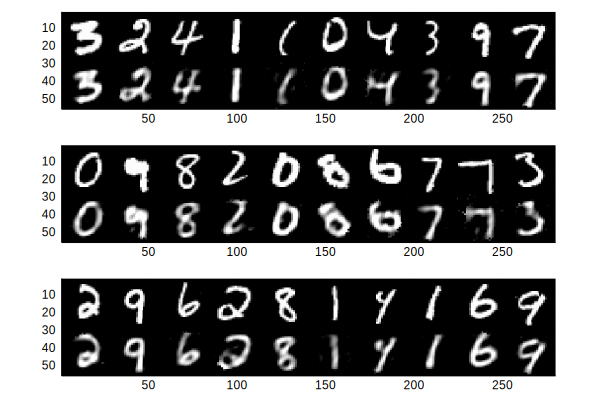

In [9]:
# Sample output
# using Images

toimg(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))

function sample(testimgs, N)
    # Sample some random digits
    before = [testimgs[i] for i in rand(1:length(testimgs), N)]
    # Before and after images
    after = toimg.(map(x -> cpu(model)(float(vec(x))).data, before))
    # Stack them all together
    hcat(vcat.(before, after)...)
end

testimgs = MNIST.images(:test)

plot([heatmap(sample(testimgs, 10)) for i=1:3]...,
     aspectratio=1,
     layout=(3,1)
)
